In [1]:

from dotenv import load_dotenv
load_dotenv( override=True)

True

### MY EXAMPLE FOR DIFFERENT TYPES OF RUN

In [5]:
from langsmith import traceable
from openai import OpenAI
from typing import List, Optional
import json

# Initialize the OpenAI client (assuming API key is set in environment variables)
openai_client = OpenAI()

@traceable(
)
def calculate_expression(expression: str) -> float:
    """
    Executes a simple mathematical expression provided as a string.
    Example: '10 + 5' -> 15
    """
    result = eval(expression)
    return float(result)

@traceable()
def call_openai_math(
    messages: List[dict], tools: Optional[List[dict]]
) -> str:
    """A wrapper for the OpenAI API call."""
    return openai_client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        temperature=0,
        tools=tools
    )

@traceable(run_type="chain")
def solve_math_problem(inputs: List[dict], tools: List[dict]):
    """
    The main chain that uses the LLM to identify a math problem and then calls
    the calculation tool to solve it.
    """

    response = call_openai_math(inputs, tools)

    tool_call = response.choices[0].message.tool_calls[0]
    tool_call_args = json.loads(tool_call.function.arguments)

    expression = tool_call_args["expression"]

    calculation_result = calculate_expression(expression)

    tool_response_message = {
        "role": "tool",
        "content": json.dumps({
            "expression": expression,
            "result": calculation_result,
        }),
        "tool_call_id": tool_call.id
    }

    inputs.append(response.choices[0].message)
    inputs.append(tool_response_message)

    output = call_openai_math(inputs, None)
    return output

math_tools = [
    {
      "type": "function",
      "function": {
        "name": "calculate_expression",
        "description": "Calculate the result of a simple arithmetic expression.",
        "parameters": {
          "type": "object",
          "properties": {
            "expression": {
              "type": "string",
              "description": "The arithmetic expression to calculate, e.g., '5 * 10 / 2'."
            }
          },
          "required": ["expression"]
        }
      }
    }
]

math_inputs = [
  {"role": "system", "content": "You are a precise calculator assistant. Use the 'calculate_expression' tool for all math."},
  {"role": "user", "content": "What is 45 times 9, divided by 3?"},
]


Here we can see that our llm decides that we need to execute the tool:

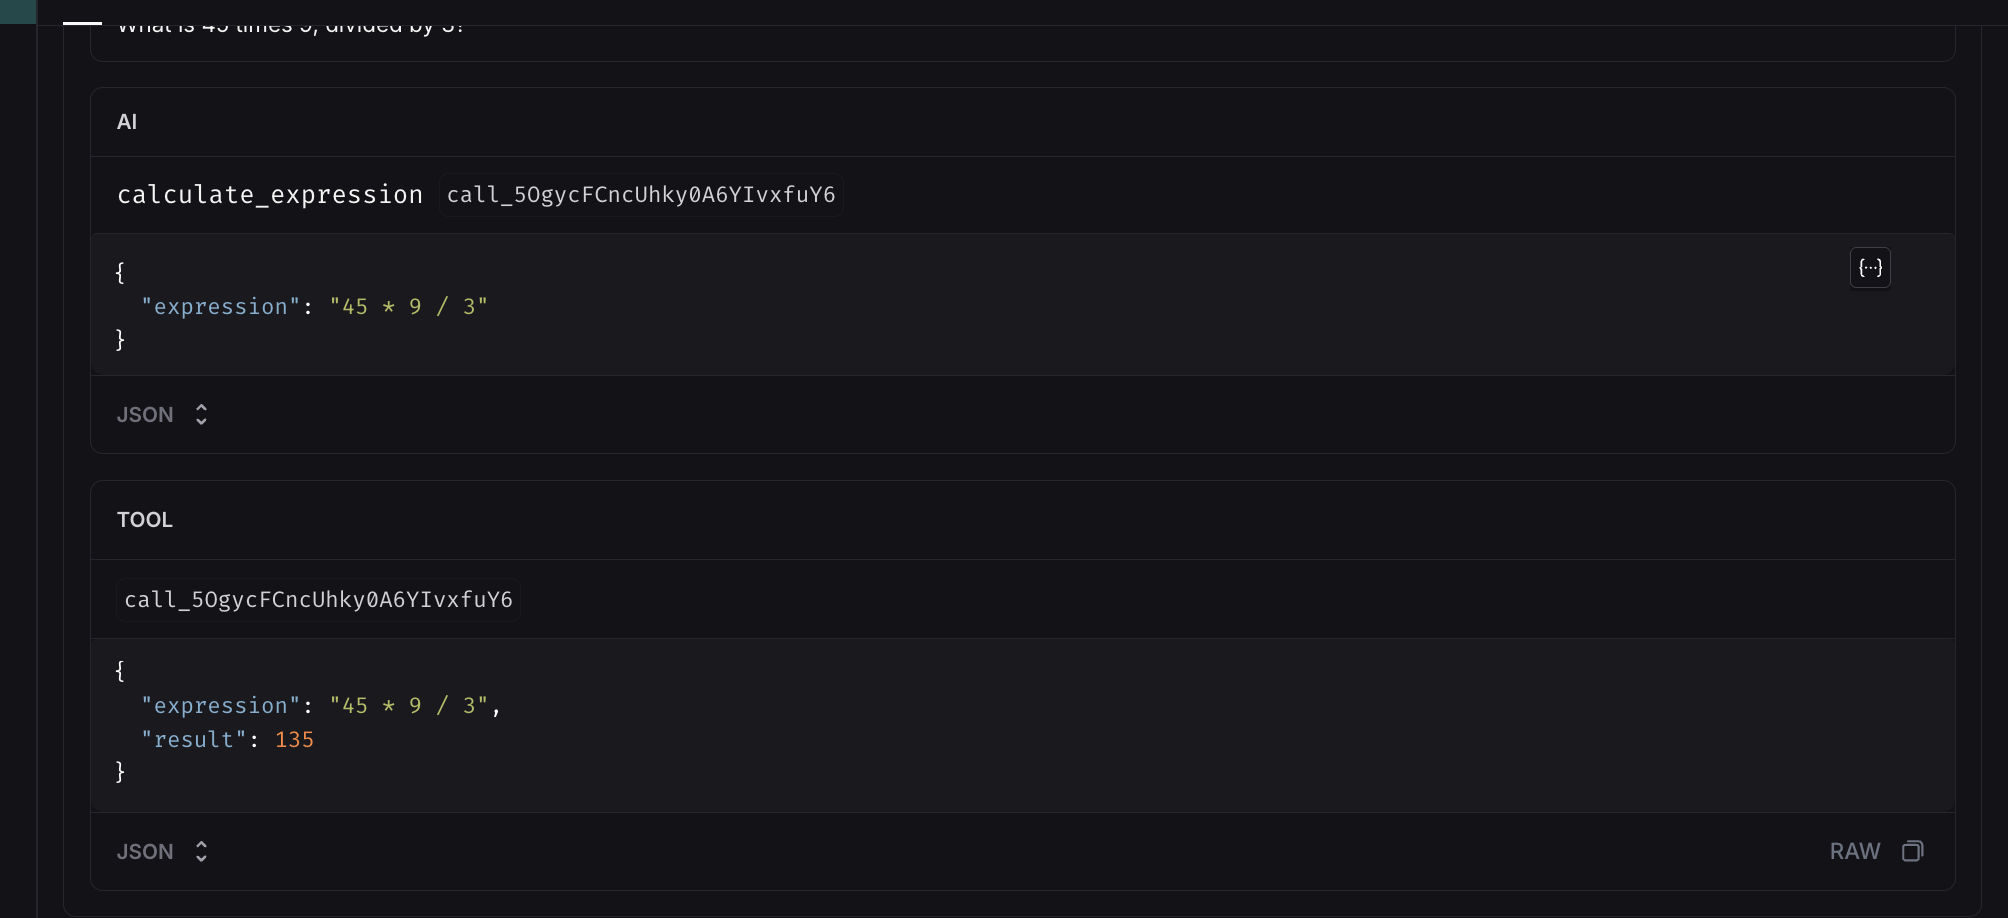

It then executes the tool and gives the output in raw form:

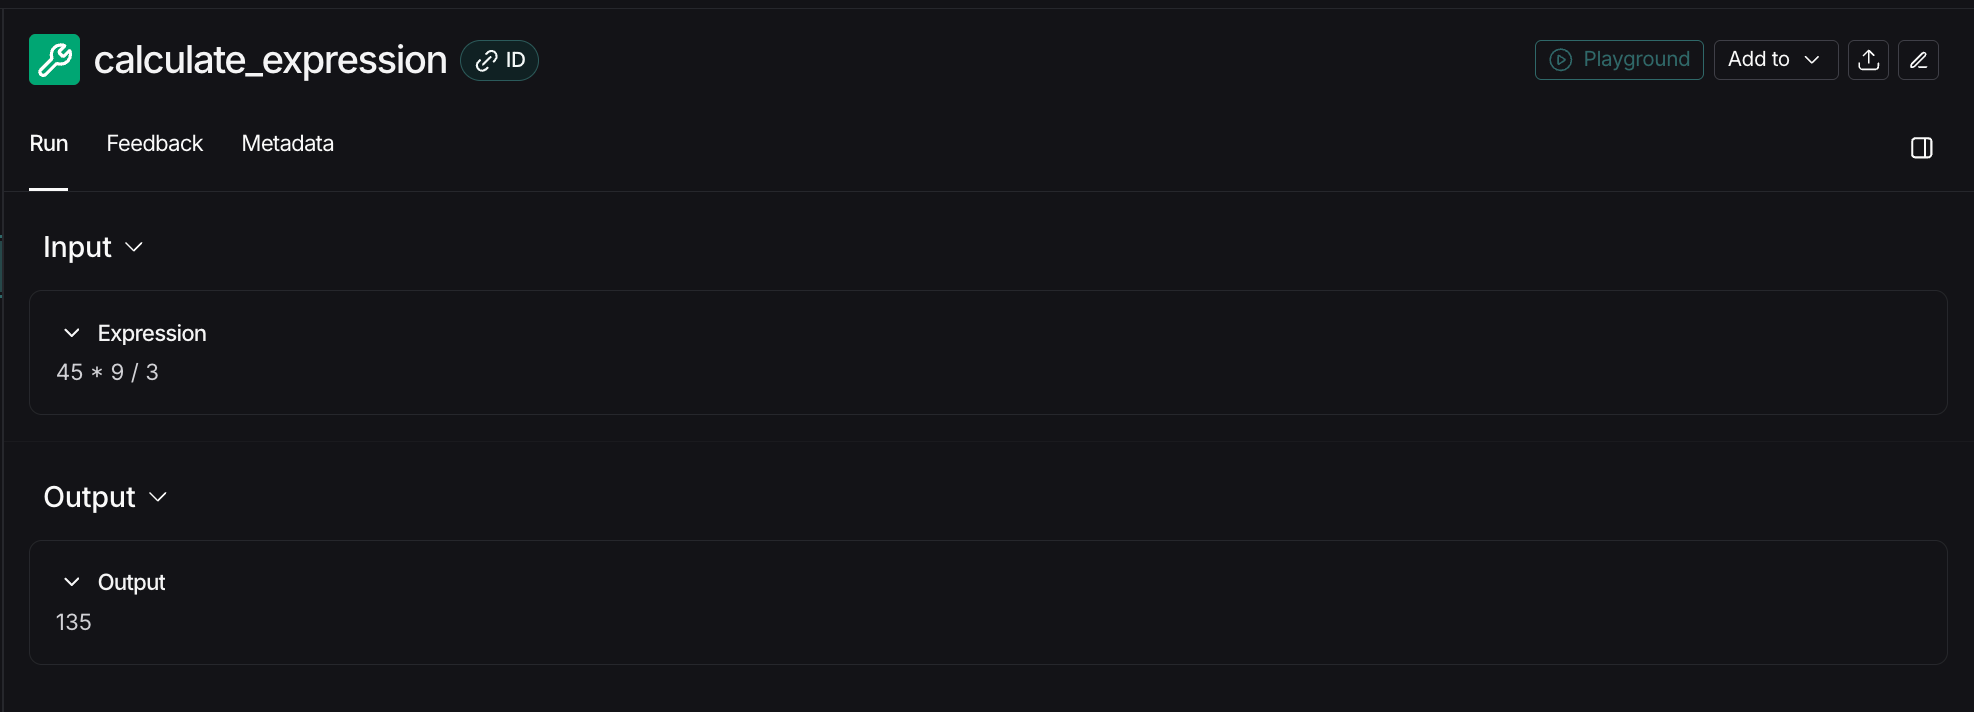

Then the llm gives us the final result in a fomratted form because we used the llm run type:

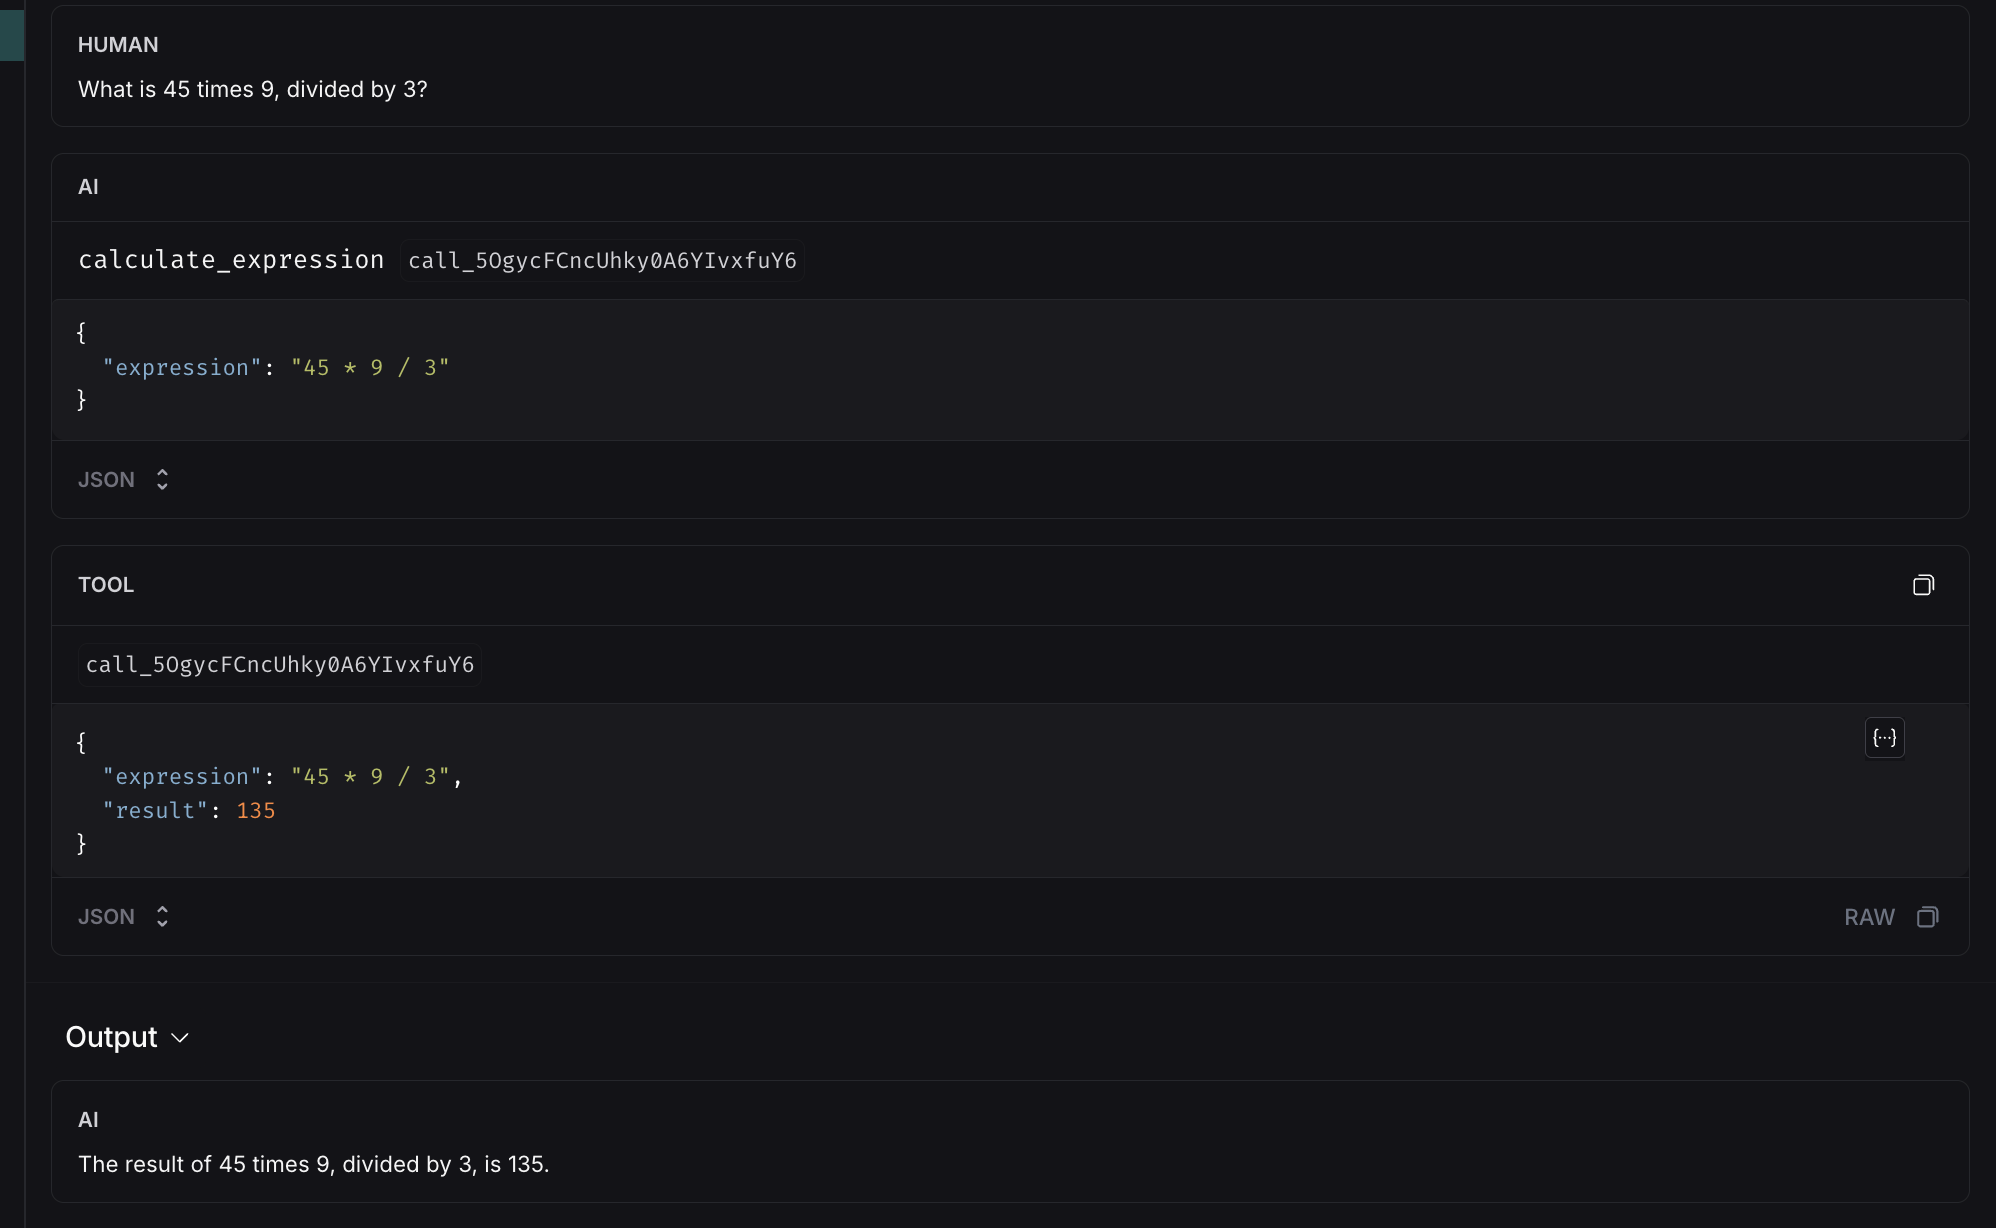

Same output without llm run type looks like this:

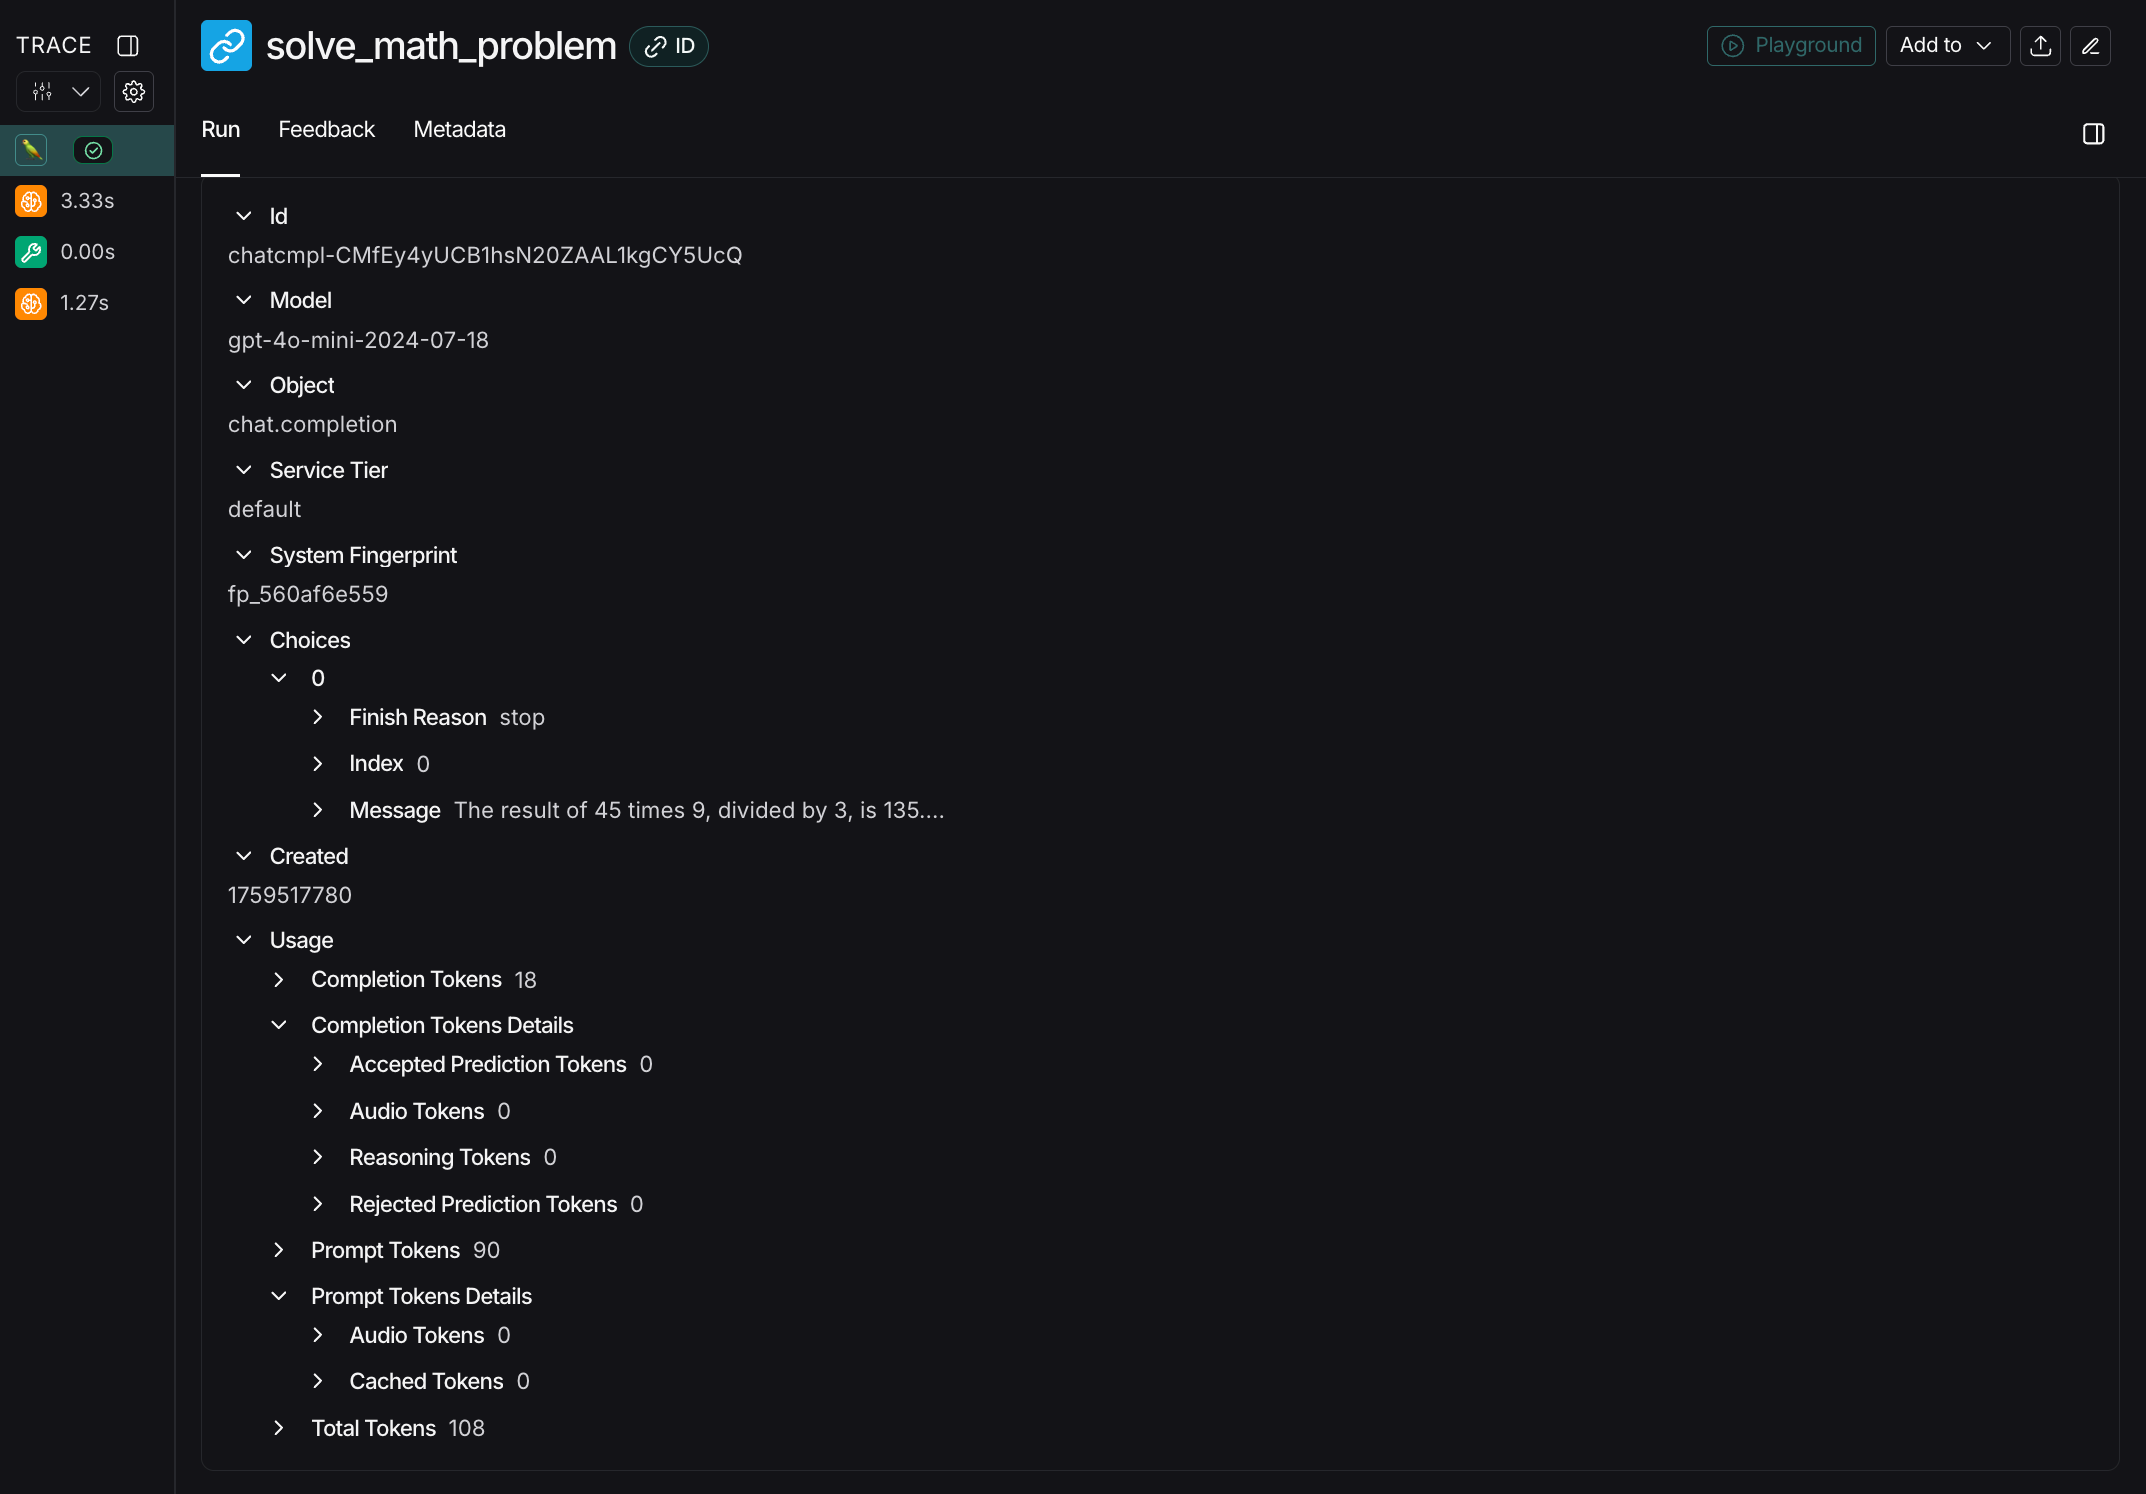






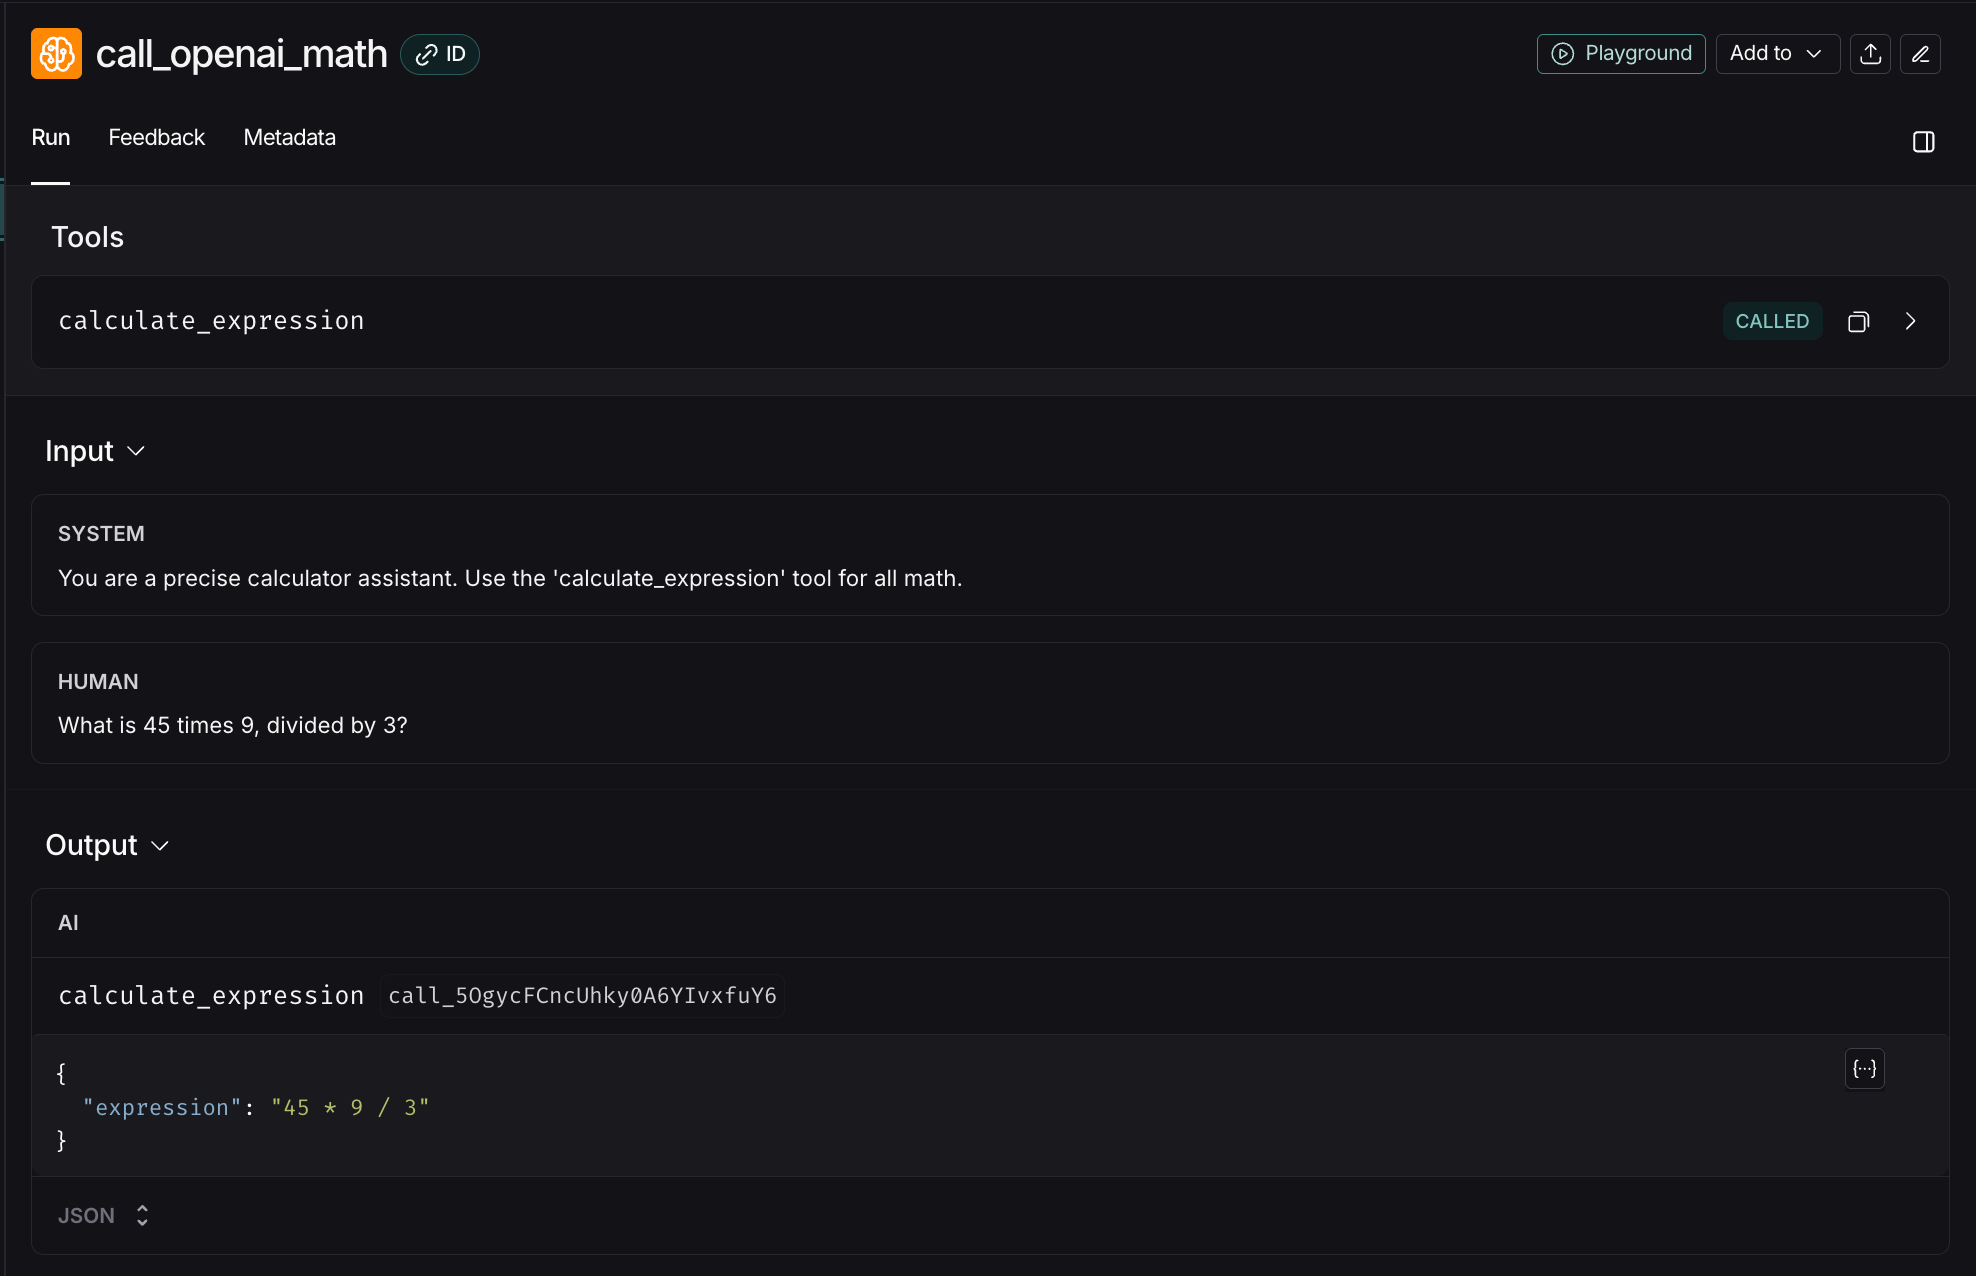